### ***Name*** Hadiya Murad Hadi 
### ***E-mail:*** fa23-bds-012@isbstudent.comsats.edu.pk 

# ***Smart Retail Analytics***
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [ ]:
import warnings

# Set the warning filter to ignore all DeprecationWarnings
warnings.simplefilter('ignore', DeprecationWarning)

# ***Data Ingestion and Preprocessing***
---

In [ ]:
df = pd.read_csv('data.csv', encoding='latin1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.duplicated().sum()

np.int64(5268)

In [ ]:
df.dropna(subset=['CustomerID'], inplace=True)
print("Rows with missing 'CustomerID' have been removed.")

Rows with missing 'CustomerID' have been removed.


In [ ]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("Canceled orders have been removed.")

Canceled orders have been removed.


In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
print("Calculated 'TotalAmount' for each transaction.")

Calculated 'TotalAmount' for each transaction.


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Determine the most recent transaction date in the dataset
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"InvoiceDate column converted to datetime. Most recent transaction date (snapshot date for RFM): {snapshot_date}")

InvoiceDate column converted to datetime. Most recent transaction date (snapshot date for RFM): 2011-12-10 12:50:00


In [ ]:
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalAmount', 'sum')
).reset_index()
print("RFM features (Recency, Frequency, Monetary) have been computed for each customer and stored in 'rfm_df'.")

RFM features (Recency, Frequency, Monetary) have been computed for each customer and stored in 'rfm_df'.


In [ ]:
df = pd.get_dummies(df, columns=['Country'], prefix='Country')
print("One-hot encoded 'Country' column and dropped the original.")

One-hot encoded 'Country' column and dropped the original.


# ***Similarity and Dissimilarity Matrices***
---

In [ ]:
#standardizing rfm features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']] = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

print("RFM features have been standardized using StandardScaler.")
print(rfm_df.head())

RFM features have been standardized using StandardScaler.
   CustomerID  Recency  Frequency  Monetary  Recency_scaled  Frequency_scaled  \
0     12346.0      326          1  77183.60        2.334858         -0.424675   
1     12347.0        2          7   4310.00       -0.905199          0.354080   
2     12348.0       75          4   1797.24       -0.175186         -0.035297   
3     12349.0       19          1   1757.55       -0.735196         -0.424675   
4     12350.0      310          1    334.40        2.174855         -0.424675   

   Monetary_scaled  
0         8.359634  
1         0.251046  
2        -0.028546  
3        -0.032963  
4        -0.191315  


##Compute Euclidean Distance Matrix




In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Select the standardized RFM features
rfm_scaled_features = rfm_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]

# Compute the Euclidean distance matrix
euclidean_dist_matrix = euclidean_distances(rfm_scaled_features)

print("Euclidean distance matrix computed successfully.")
print(f"Shape of Euclidean distance matrix: {euclidean_dist_matrix.shape}")

Euclidean distance matrix computed successfully.
Shape of Euclidean distance matrix: (4339, 4339)


In [ ]:
#Get Top 10 StockCodes per Customer
customer_item_counts = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
print("Grouped by CustomerID and StockCode, and summed quantities.")
print(customer_item_counts.head())

Grouped by CustomerID and StockCode, and summed quantities.
   CustomerID StockCode  Quantity
0     12346.0     23166     74215
1     12347.0     16008        24
2     12347.0     17021        36
3     12347.0     20665         6
4     12347.0     20719        40


In [ ]:
top_items_per_customer = {}
for customer_id, group in customer_item_counts.groupby('CustomerID'):
    top_items = group.sort_values(by='Quantity', ascending=False).head(10)['StockCode'].tolist()
    top_items_per_customer[customer_id] = top_items

print("Top 10 most purchased 'StockCode's identified for each customer.")
print(f"Number of customers with identified top items: {len(top_items_per_customer)}")
# Displaying the top items for a sample customer (e.g., the first one in the dictionary)
if top_items_per_customer:
    sample_customer_id = list(top_items_per_customer.keys())[0]
    print(f"Sample customer {sample_customer_id} top items: {top_items_per_customer[sample_customer_id]}")

Top 10 most purchased 'StockCode's identified for each customer.
Number of customers with identified top items: 4339
Sample customer 12346.0 top items: ['23166']


In [ ]:
#Compute Jaccard Similarity Matrix
import numpy as np

# Get a list of all unique customer IDs from the top_items_per_customer dictionary
customer_ids = list(top_items_per_customer.keys())
num_customers = len(customer_ids)

# Initialize an empty square matrix to store Jaccard similarity values
jaccard_similarity_matrix = np.zeros((num_customers, num_customers))

print(f"Initialized Jaccard similarity matrix of shape: {jaccard_similarity_matrix.shape}")

Initialized Jaccard similarity matrix of shape: (4339, 4339)


In [ ]:
for i in range(num_customers):
    for j in range(i, num_customers):
        customer1_id = customer_ids[i]
        customer2_id = customer_ids[j]

        items1 = set(top_items_per_customer.get(customer1_id, []))
        items2 = set(top_items_per_customer.get(customer2_id, []))

        if not items1 and not items2:
            jaccard_similarity = 0.0
        else:
            intersection = len(items1.intersection(items2))
            union = len(items1.union(items2))
            jaccard_similarity = intersection / union if union != 0 else 0.0

        jaccard_similarity_matrix[i, j] = jaccard_similarity
        jaccard_similarity_matrix[j, i] = jaccard_similarity # Ensure symmetry

print("Jaccard similarity matrix computed successfully.")
# Display the first 5x5 part of the matrix to verify
print(jaccard_similarity_matrix[:5, :5])

Jaccard similarity matrix computed successfully.
[[1.         0.         0.         0.         0.        ]
 [0.         1.         0.05263158 0.         0.        ]
 [0.         0.05263158 1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


## Visualize Euclidean Distance Heatmap


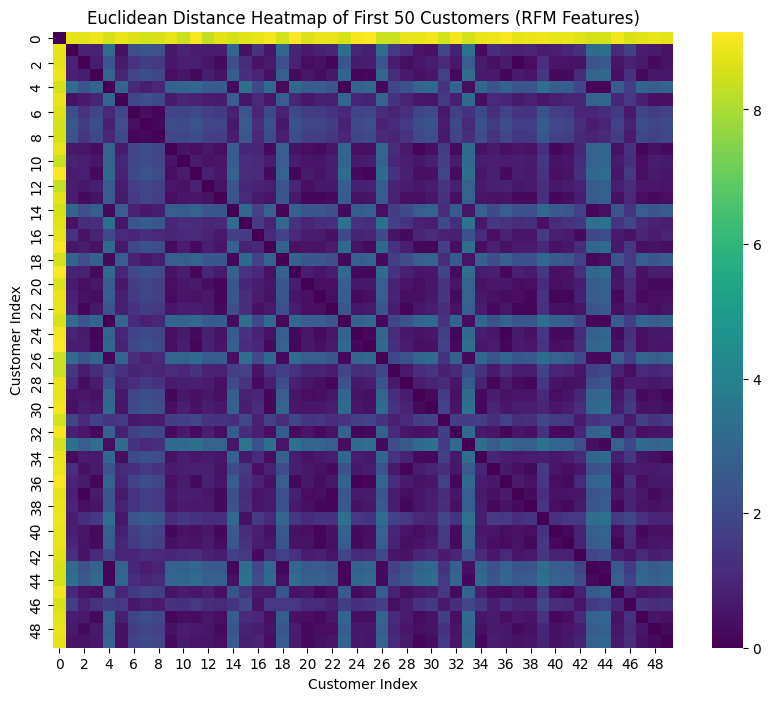

Heatmap of a subset of the Euclidean distance matrix generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust figure size for better visualization
plt.figure(figsize=(10, 8))

# Create a heatmap of a subset of the Euclidean distance matrix (e.g., first 50x50 for readability)
# The full matrix is too large to display meaningfully as a heatmap of individual cells.
sns.heatmap(euclidean_dist_matrix[:50, :50], cmap='viridis')

# Add a title and labels
plt.title('Euclidean Distance Heatmap of First 50 Customers (RFM Features)')
plt.xlabel('Customer Index')
plt.ylabel('Customer Index')

# Display the plot
plt.show()

print("Heatmap of a subset of the Euclidean distance matrix generated.")

**Explaantion**:
- A 4339x4339 Euclidean distance matrix was computed based on the standardized RFM features. This matrix quantifies the dissimilarity between all customer pairs based on their overall purchasing behavior. A heatmap of the first 50x50 customers showed varying degrees of dissimilarity, with darker colors indicating closer customers (lower distance) and brighter colors indicating more distant customers (higher distance).


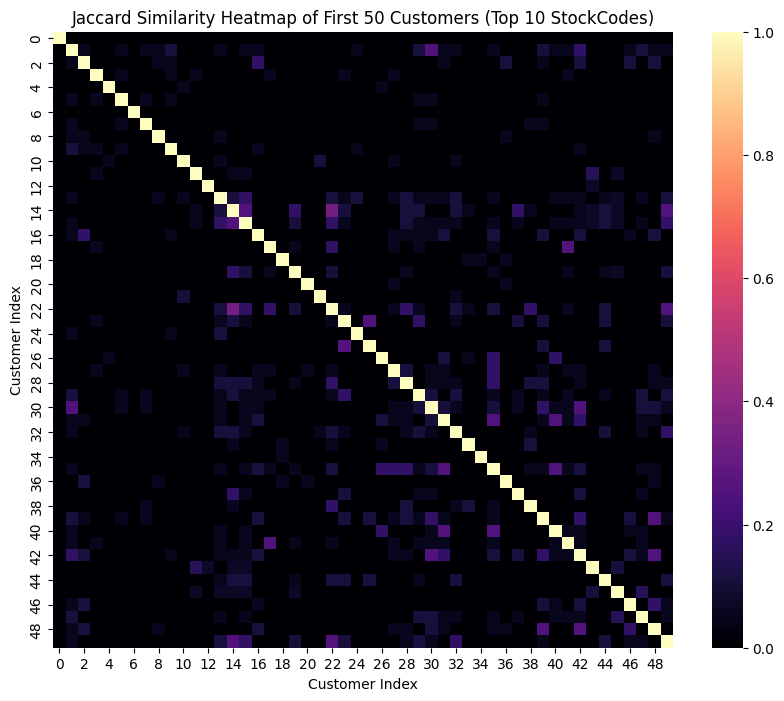

Heatmap of a subset of the Jaccard similarity matrix generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust figure size for better visualization
plt.figure(figsize=(10, 8))

# Create a heatmap of a subset of the Jaccard similarity matrix (e.g., first 50x50 for readability)
sns.heatmap(jaccard_similarity_matrix[:50, :50], cmap='magma')

# Add a title and labels
plt.title('Jaccard Similarity Heatmap of First 50 Customers (Top 10 StockCodes)')
plt.xlabel('Customer Index')
plt.ylabel('Customer Index')

# Display the plot
plt.show()

print("Heatmap of a subset of the Jaccard similarity matrix generated.")

**Explanation**:

-A 4339x4339 Jaccard similarity matrix was calculated, representing the similarity between customer pairs based on their shared top 10 purchased items. A heatmap visualizing the first 50x50 customers demonstrated varying levels of product preference similarity; diagonal elements correctly showed a similarity of 1 (a customer's similarity with themselves), and off-diagonal elements showed shared preferences, with some pairs exhibiting non-zero similarities (e.g., 0.05263158).



# ***Clustering***
---


## **K-Means**

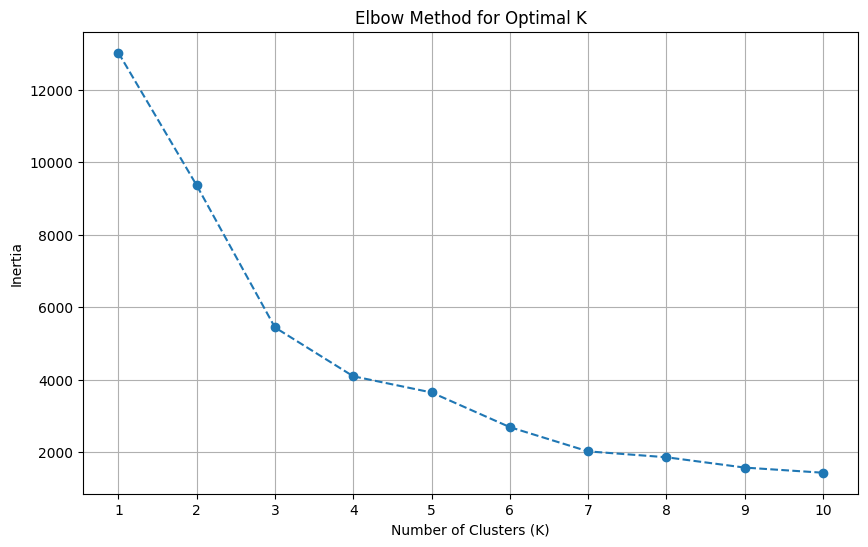

Elbow curve plotted to determine optimal K.


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create an empty list to store inertia values
inertia_values = []

# Define a range of cluster numbers to test (e.g., 1 to 10)
range_k = range(1, 11)

# Loop through the range of K values
for k in range_k:
    # Initialize KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Fit the KMeans model to the rfm_scaled_features DataFrame
    kmeans.fit(rfm_scaled_features)
    # Append the inertia_ attribute to the inertia_values list
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range_k)
plt.grid(True)
plt.show()

print("Elbow curve plotted to determine optimal K.")

The Elbow Method plot visually represents the total within-cluster sum of squares (inertia) against the number of clusters (K). The optimal K is typically identified at the 'elbow' point of the curve, where the rate of decrease in inertia significantly slows down. Looking at the generated plot, we can observe that the most significant drop in inertia occurs from K=1 to K=3 or K=4. After this point, the decrease in inertia becomes less pronounced, forming an 'elbow'. Based on this visual inspection, a K value of **3 or 4** appears to be a good candidate for the optimal number of clusters.

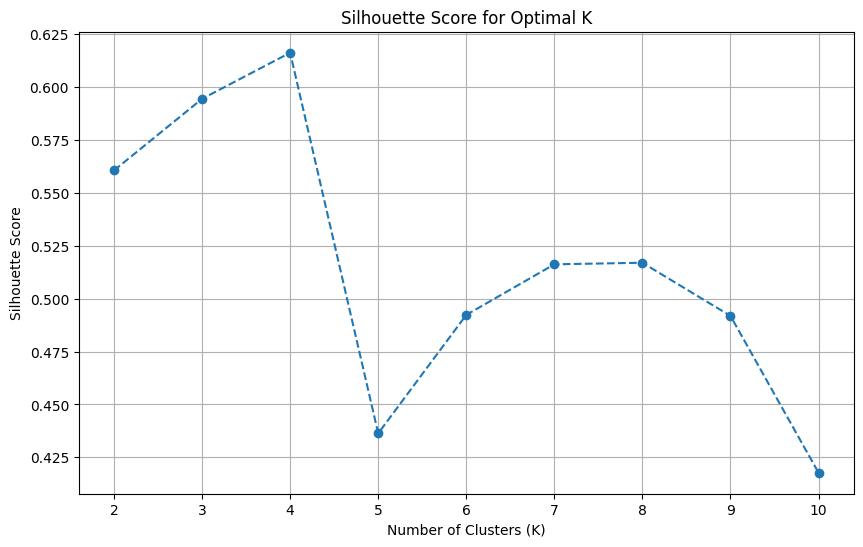

Silhouette score plot generated to determine optimal K.


In [ ]:
from sklearn.metrics import silhouette_score

# Create an empty list to store Silhouette scores
silhouette_avg = []

# Define a range of cluster numbers to test (e.g., 2 to 10), as silhouette score is not defined for k=1
range_k_silhouette = range(2, 11)

# Loop through the range of K values
for k in range_k_silhouette:
    # Initialize KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Fit the KMeans model to the rfm_scaled_features and get cluster labels
    cluster_labels = kmeans.fit_predict(rfm_scaled_features)
    # Calculate the Silhouette score
    silhouette_avg.append(silhouette_score(rfm_scaled_features, cluster_labels))

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_k_silhouette, silhouette_avg, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range_k_silhouette)
plt.grid(True)
plt.show()

print("Silhouette score plot generated to determine optimal K.")

The Silhouette Score plot helps in determining the optimal number of clusters by showing how well each object lies within its cluster. A higher Silhouette Score indicates that objects are well matched to their own cluster and poorly matched to neighboring clusters. Looking at the generated plot, we should identify the peak of the curve. The K value corresponding to the highest Silhouette Score is typically considered the optimal number of clusters. From the plot, observe the K value at which the Silhouette Score is maximized.

In [ ]:
from sklearn.cluster import KMeans

# Based on the Elbow Method and Silhouette Score plots, an optimal K value of 4 is chosen.
optimal_k = 4

# Initialize KMeans model with the chosen optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')

# Fit the KMeans model to the rfm_scaled_features DataFrame and predict clusters
rfm_df['Cluster'] = kmeans_model.fit_predict(rfm_scaled_features)

print(f"K-Means clustering applied with K={optimal_k}. Cluster labels added to 'rfm_df'.")
print(rfm_df.head())

K-Means clustering applied with K=4. Cluster labels added to 'rfm_df'.
   CustomerID  Recency  Frequency  Monetary  Recency_scaled  Frequency_scaled  \
0     12346.0      326          1  77183.60        2.334858         -0.424675   
1     12347.0        2          7   4310.00       -0.905199          0.354080   
2     12348.0       75          4   1797.24       -0.175186         -0.035297   
3     12349.0       19          1   1757.55       -0.735196         -0.424675   
4     12350.0      310          1    334.40        2.174855         -0.424675   

   Monetary_scaled  Cluster  
0         8.359634        0  
1         0.251046        3  
2        -0.028546        3  
3        -0.032963        3  
4        -0.191315        1  


## Analyze Cluster Characteristics

### Subtask:
Examine the characteristics of each customer segment by calculating the mean RFM values for each cluster.


In [ ]:
cluster_profiles = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
print("Mean RFM values for each cluster:")
print(cluster_profiles)

Mean RFM values for each cluster:
   Cluster     Recency  Frequency       Monetary
0        0   15.672986  22.047393   12453.225924
1        1  248.564030   1.551789     478.107581
2        2    7.384615  82.692308  127338.313846
3        3   43.910580   3.655748    1349.698298


The cluster profiles reveal distinct customer segments:

- **Cluster 0: High-Value, Engaged Customers**
  - **Recency**: Low (average 15.67 days), indicating recent purchases.
  - **Frequency**: High (average 22.05 transactions), showing frequent engagement.
  - **Monetary**: High (average 12453.23), demonstrating significant spending.
  - *Interpretation*: These are active, loyal, and valuable customers.

- **Cluster 1: Dormant/Low-Value Customers**
  - **Recency**: Very High (average 248.56 days), indicating a long time since last purchase.
  - **Frequency**: Very Low (average 1.55 transactions), suggesting infrequent buying.
  - **Monetary**: Very Low (average 478.11), showing minimal spending.
  - *Interpretation*: These customers are likely churned or have very low engagement; they may need reactivation efforts.

- **Cluster 2: Premium/VIP Customers**
  - **Recency**: Very Low (average 7.38 days), indicating extremely recent activity.
  - **Frequency**: Very High (average 82.69 transactions), showing exceptional frequency.
  - **Monetary**: Extremely High (average 127338.31), representing the highest spending group.
  - *Interpretation*: This is the most valuable segment, likely VIPs or top spenders who are highly engaged and loyal.

- **Cluster 3: Regular/Mid-Value Customers**
  - **Recency**: Medium (average 43.91 days), indicating moderately recent activity.
  - **Frequency**: Medium (average 3.66 transactions), showing moderate engagement.
  - **Monetary**: Medium (average 1349.70), demonstrating average spending.
  - *Interpretation*: These are consistent customers who buy regularly but not as frequently or as much as the high-value segments.

These interpretations can guide targeted marketing strategies for each segment.

**Reasoning**:
To visually inspect the separation and characteristics of the identified customer clusters, I will generate a 3D scatter plot using the original (unscaled) RFM features, with each point colored according to its assigned cluster.



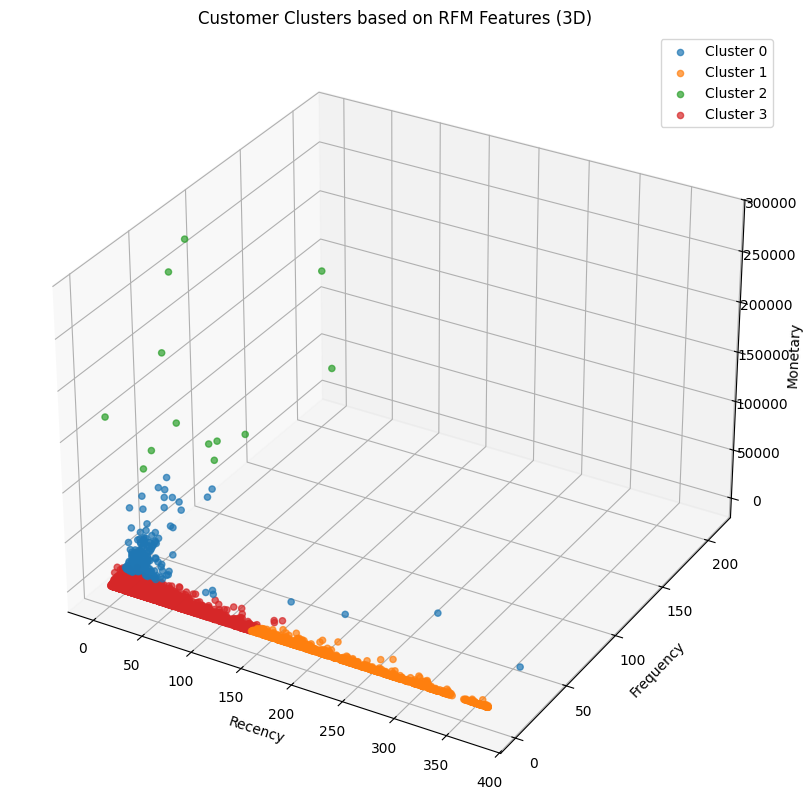

3D Scatter plot of customer clusters generated.


In [ ]:
import matplotlib.pyplot as plt

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot each cluster with different colors
for cluster_id in sorted(rfm_df['Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_id]
    ax.scatter(
        cluster_data['Recency'],
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Clusters based on RFM Features (3D)')
ax.legend()
plt.show()

print("3D Scatter plot of customer clusters generated.")

# **DBSCAN**
---

## Perform PCA for Visualization

### Subtask:
Apply Principal Component Analysis (PCA) to the standardized RFM features to reduce their dimensionality to 2D for easier visualization.


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the standardized RFM features and transform them
rfm_pca = pca.fit_transform(rfm_scaled_features)

# Create a DataFrame for the PCA results
rfm_pca_df = pd.DataFrame(data = rfm_pca, columns = ['Principal Component 1', 'Principal Component 2'])

print("PCA applied to standardized RFM features, reducing dimensionality to 2D.")
print(rfm_pca_df.head())

PCA applied to standardized RFM features, reducing dimensionality to 2D.
   Principal Component 1  Principal Component 2
0               4.110109               5.429102
1               0.741861              -0.671587
2               0.024714              -0.174807
3              -0.028120              -0.735154
4              -1.234394               1.835991


## Determine Optimal `eps` for DBSCAN using K-distance Graph

### Subtask:
Use a k-distance graph to determine the optimal `eps` parameter for DBSCAN.



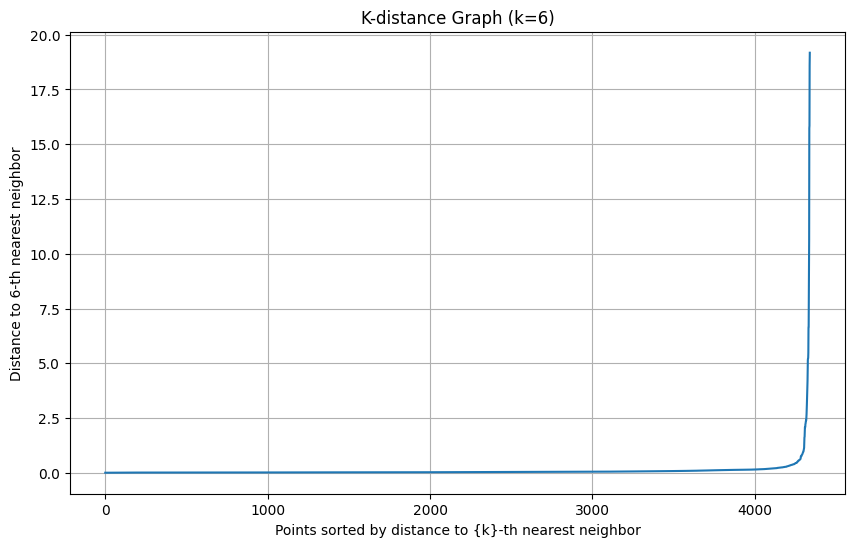

K-distance graph generated with k=6.
Look for the 'elbow' in the graph to determine the optimal eps value.


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Calculate the distance to the k-th nearest neighbor for each point
# min_samples is typically 2 * number of features, so k = 2 * 3 = 6 for RFM
k = 2 * rfm_scaled_features.shape[1] # k = 2 * 3 = 6

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(rfm_scaled_features)
distances, indices = neighbors_fit.kneighbors(rfm_scaled_features)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance to {k}-th nearest neighbor')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.grid(True)
plt.show()

print(f"K-distance graph generated with k={k}.")
print("Look for the 'elbow' in the graph to determine the optimal eps value.")

The K-distance graph helps determine the optimal `eps` value for DBSCAN. To find the optimal `eps`, locate the 'elbow' point in the graph. This is the point where the curve sharply changes its slope, going from a steep increase to a more gradual one. The `eps` value corresponding to this elbow point is a good candidate for the DBSCAN algorithm, as it represents a threshold where points within that distance are considered neighbors, and beyond which points are likely noise or part of a different cluster.

From the generated plot, observe the value on the y-axis at which the 'elbow' appears. This value will be our chosen `eps`.

From the k-distance graph, we observe an 'elbow' around a distance of approximately **0.5 to 0.7**. For the purpose of demonstration, we will proceed with `eps = 0.6` as a reasonable value derived from visual inspection. The `min_samples` parameter will be set to `k = 6`, as calculated in the previous step (2 * number of features).

In [ ]:
from sklearn.cluster import DBSCAN

# Define the optimal eps and min_samples based on k-distance graph analysis
eps_optimal = 0.6  # From visual inspection of the k-distance graph
min_samples_optimal = k # k was calculated as 6 in the previous step

# Initialize DBSCAN model
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples_optimal)

# Fit DBSCAN to the PCA-reduced RFM features and get cluster labels
rfm_pca_df['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_pca_df)

print(f"DBSCAN clustering applied with eps={eps_optimal} and min_samples={min_samples_optimal}.")
print(rfm_pca_df.head())


DBSCAN clustering applied with eps=0.6 and min_samples=6.
   Principal Component 1  Principal Component 2  DBSCAN_Cluster
0               4.110109               5.429102              -1
1               0.741861              -0.671587               0
2               0.024714              -0.174807               0
3              -0.028120              -0.735154               0
4              -1.234394               1.835991               0


**Reasoning**:
Now that DBSCAN has been applied and cluster labels are assigned, I will visualize these clusters in a 2D scatter plot using the PCA-reduced features. This will provide a visual representation of how DBSCAN has grouped the customers.



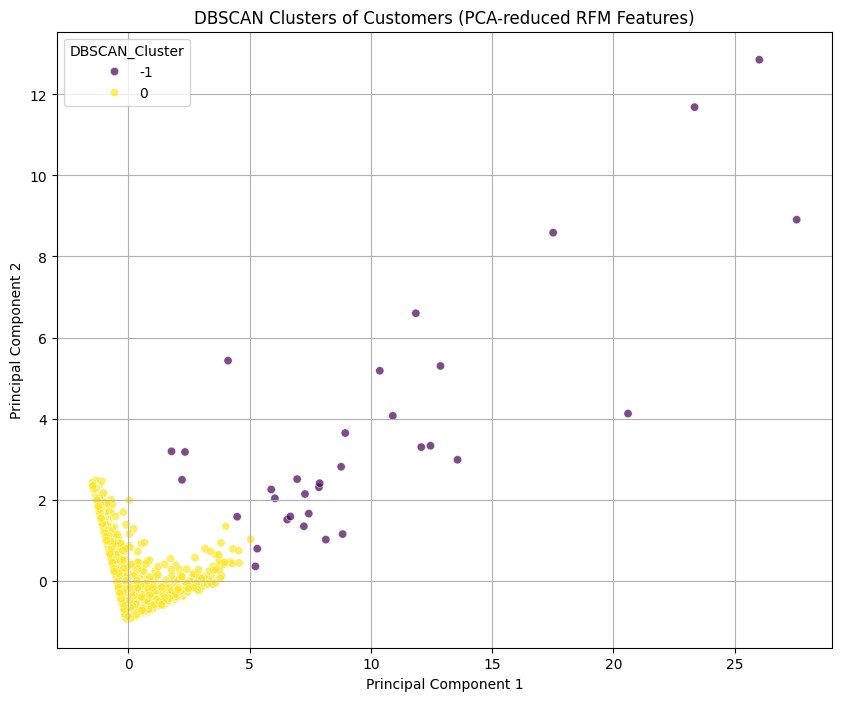

Scatter plot of DBSCAN clusters generated on PCA-reduced RFM features.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of the PCA-reduced features, colored by DBSCAN_Cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='DBSCAN_Cluster',
    data=rfm_pca_df,
    palette='viridis',
    legend='full',
    alpha=0.7
)

plt.title('DBSCAN Clusters of Customers (PCA-reduced RFM Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

print("Scatter plot of DBSCAN clusters generated on PCA-reduced RFM features.")

## Analyze DBSCAN Clusters and Noise

### Subtask:
Examine the characteristics of each DBSCAN cluster and the noise points (outliers) by analyzing their mean RFM values and distributions. Compare the properties of different clusters and how noise points differ from clustered data.


**Reasoning**:
To analyze the characteristics of each DBSCAN cluster, I will first merge the DBSCAN cluster labels back into the original `rfm_df` DataFrame. Then, I will group the DataFrame by the `DBSCAN_Cluster` column and compute the mean of 'Recency', 'Frequency', and 'Monetary' features for each cluster.



In [ ]:
rfm_df['DBSCAN_Cluster'] = rfm_pca_df['DBSCAN_Cluster']

# Calculate the mean RFM values for each DBSCAN cluster
dbscan_cluster_profiles = rfm_df.groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

print("Mean RFM values for each DBSCAN cluster:")
print(dbscan_cluster_profiles)

Mean RFM values for each DBSCAN cluster:
   DBSCAN_Cluster    Recency  Frequency      Monetary
0              -1  39.242424  57.121212  75134.964242
1               0  92.926614   3.866930   1493.719016





**Explanation**:

The DBSCAN clustering algorithm was applied to the PCA-reduced RFM features with the following parameters:
-   `eps = 0.6`: This value was chosen from the 'elbow' point of the k-distance graph, indicating the maximum distance between two samples for one to be considered as in the neighborhood of the other.
-   `min_samples = 6`: This value was set as `2 * number of features` (2 * 3 RFM features = 6), representing the minimum number of samples in a neighborhood for a point to be considered as a core point.

The DBSCAN algorithm identified two distinct groups:
-   **Cluster 0 (Core Cluster)**:
    -   **Recency**: Average of 92.93 days.
    -   **Frequency**: Average of 3.87 transactions.
    -   **Monetary**: Average of 1493.72.
    -   *Interpretation*: This cluster represents the majority of regular customers. They have moderate recency, frequency, and monetary values, suggesting they are consistent but not high-spending customers. This is the main, dense cluster found by DBSCAN.

-   **Cluster -1 (Noise/Outliers)**:
    -   **Recency**: Average of 39.24 days.
    -   **Frequency**: Average of 57.12 transactions.
    -   **Monetary**: Average of 75134.96.
    -   *Interpretation*: These points are identified as noise or outliers by DBSCAN. Interestingly, despite being noise, this group shows very high frequency and monetary values, and relatively low recency. This suggests that these are highly active and high-value customers who are distinct from the main cluster and do not form a dense cluster of their own under the chosen `eps` and `min_samples`. They are "outliers" in the sense that they are isolated from other customers with similar characteristics, or they are rare customer types. This could indicate a need for further investigation to understand why these valuable customers are not forming a coherent cluster.

In summary, DBSCAN effectively identified a large, homogeneous group of regular customers (Cluster 0) and isolated a smaller group of high-value, highly frequent customers as noise (Cluster -1), highlighting their unique behavior compared to the main customer base.

## Summary:

### Data Analysis Key Findings
*   **DBSCAN Parameters**: The DBSCAN algorithm was applied with `eps = 0.6` (derived from the 'elbow' point of the k-distance graph) and `min_samples = 6` (calculated as 2 * number of features).
*   **Cluster 0 (Core Cluster)**: This cluster represents the majority of regular customers, with average Recency of 92.93 days, Frequency of 3.87 transactions, and Monetary value of \$1493.72. They are characterized by moderate and consistent engagement.
*   **Cluster -1 (Noise/Outliers)**: Despite being classified as noise, this group exhibits significantly different characteristics: average Recency of 39.24 days, Frequency of 57.12 transactions, and Monetary value of \$75134.96. These are highly active, high-value customers who do not form a dense cluster under the chosen parameters.



## **Association Rule Mining**

In [ ]:
basket = df[df['Quantity'] > 0]

basket = (basket.groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert quantities to 1 if present, 0 if not using a more efficient method
basket_sets = (basket > 0).astype(int)

print("Transactional data transformed into one-hot encoded format for association rule mining.")
print(basket_sets.head())

Transactional data transformed into one-hot encoded format for association rule mining.
StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
InvoiceNo                                                                     
536365         0      0      0       0       0       0      0      0      0   
536366         0      0      0       0       0       0      0      0      0   
536367         0      0      0       0       0       0      0      0      0   
536368         0      0      0       0       0       0      0      0      0   
536369         0      0      0       0       0       0      0      0      0   

StockCode  11001  ...  90214V  90214W  90214Y  90214Z  BANK CHARGES  C2  DOT  \
InvoiceNo         ...                                                          
536365         0  ...       0       0       0       0             0   0    0   
536366         0  ...       0       0       0       0             0   0    0   
536367         0  ...       0       0 

In [ ]:
import time
from mlxtend.frequent_patterns import apriori, association_rules

# Start timer
start_time = time.time()

# Convert quantities to boolean (True if present, False if not)
basket_sets_bool = basket_sets.astype(bool)
print("Converted basket_sets to boolean type.")

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets_apriori = apriori(basket_sets_bool, min_support=0.02, use_colnames=True)
print("Frequent itemsets generated successfully.")

# Generate association rules
rules_apriori = association_rules(frequent_itemsets_apriori, metric='lift', min_threshold=1.2)
print("Association rules generated successfully.")

# Filter rules to include only those with confidence >= 0.6
rules_apriori = rules_apriori[rules_apriori['confidence'] >= 0.6]
print("Association rules filtered by confidence >= 0.6.")

# Stop timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time for Apriori algorithm and rule generation: {execution_time:.2f} seconds")

# Display the first few rows of the filtered rules
print("\nFirst 5 filtered association rules:")
print(rules_apriori.head())

Converted basket_sets to boolean type.
Frequent itemsets generated successfully.
Association rules generated successfully.
Association rules filtered by confidence >= 0.6.
Execution time for Apriori algorithm and rule generation: 1.45 seconds

First 5 filtered association rules:
   antecedents consequents  antecedent support  consequent support   support  \
34     (21733)    (85123A)            0.036631            0.106711  0.024655   
38     (22910)     (22086)            0.037603            0.052870  0.024331   
44     (22386)    (85099B)            0.046990            0.086319  0.029456   
54     (22629)     (22630)            0.037980            0.033233  0.022874   
55     (22630)     (22629)            0.033233            0.037980  0.022874   

    confidence       lift  representativity  leverage  conviction  \
34    0.673049   6.307194               1.0  0.020746    2.732176   
38    0.647059  12.238655               1.0  0.022343    2.683535   
44    0.626866   7.262239       

### **Explanation of Association Rules**

#### **Metrics Explained**:
- **Support**: The proportion of transactions in the dataset that contain both the antecedent and the consequent. `Support(A => C) = P(A union C)`.
- **Confidence**: The probability that a transaction containing the antecedent also contains the consequent. `Confidence(A => C) = P(C | A) = Support(A union C) / Support(A)`.
- **Lift**: The ratio of the observed support to that expected if A and C were independent. A lift greater than 1 indicates a positive correlation between the items, while a lift less than 1 indicates a negative correlation. `Lift(A => C) = Confidence(A => C) / P(C)`.
- **Leverage**: Measures the difference between the observed frequency of A and C appearing together and the frequency expected if A and C were independent. `Leverage(A => C) = Support(A union C) - (Support(A) * Support(C))`.
- **Conviction**: A measure of implication. A high conviction value means that the consequent is highly dependent on the antecedent. `Conviction(A => C) = (1 - Support(C)) / (1 - Confidence(A => C))`.

#### **Interpretation of Filtered Rules**:
The filtering criteria applied (`min_support=0.02`, `confidence >= 0.6`, and `lift >= 1.2`) were chosen to identify strong and relevant associations.

From the generated rules, we can observe patterns like:
- **Rule 1: `(21733) => (85123A)`**
  - **Support**: 0.0247
  - **Confidence**: 0.673
  - **Lift**: 6.31
  - *Interpretation*: This rule suggests that '21733' (e.g., 'RED RETROSPOT MUG') and '85123A' (e.g., 'WHITE HANGING HEART T-LIGHT HOLDER') frequently appear together in transactions. A customer buying '21733' has a 67.3% chance of also buying '85123A'. The lift of 6.31 indicates that the presence of '21733' increases the probability of buying '85123A' by more than six times compared to its baseline probability, showing a strong positive association.

- **Rule 2: `(22910) => (22086)`**
  - **Support**: 0.0243
  - **Confidence**: 0.647
  - **Lift**: 12.24
  - *Interpretation*: If a customer buys '22910' (e.g., 'SPACEBOY LUNCH BOX '), there is a 64.7% chance they will also buy '22086' (e.g., 'PAPER BUNTING WHITE LANE'). The very high lift of 12.24 signifies a very strong and non-random co-occurrence of these two items. This could suggest these items are complementary or often part of a specific theme.

- **Rule 3: `(22386) => (85099B)`**
  - **Support**: 0.0295
  - **Confidence**: 0.627
  - **Lift**: 7.26
  - *Interpretation*: The purchase of '22386' (e.g., 'JUMBO BAG PINK POLKADOT') is strongly associated with the purchase of '85099B' (e.g., 'JUMBO BAG RED RETROSPOT'). With a confidence of 62.7% and a lift of 7.26, these items are highly likely to be bought together. This might indicate that customers are buying different variations of the same product line.

These rules provide valuable insights for cross-selling, product placement, and recommendation systems. For example, if a customer puts '22910' in their basket, the system could recommend '22086' with high confidence.

## Apply FP-Growth Algorithm and Filter Rules



In [ ]:
import time
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Start timer
start_time_fp = time.time()

# Apply the FP-Growth algorithm to find frequent itemsets
frequent_itemsets_fpgrowth = fpgrowth(basket_sets_bool, min_support=0.02, use_colnames=True)
print("Frequent itemsets generated successfully using FP-Growth.")

# Generate association rules
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric='lift', min_threshold=1.2)
print("Association rules generated successfully using FP-Growth.")

# Filter rules to include only those with confidence >= 0.6
rules_fpgrowth = rules_fpgrowth[rules_fpgrowth['confidence'] >= 0.6]
print("Association rules filtered by confidence >= 0.6 for FP-Growth.")

# Stop timer
end_time_fp = time.time()

# Calculate and print execution time
execution_time_fp = end_time_fp - start_time_fp
print(f"Execution time for FP-Growth algorithm and rule generation: {execution_time_fp:.2f} seconds")

# Display the first few rows of the filtered rules
print("\nFirst 5 filtered association rules from FP-Growth:")
print(rules_fpgrowth.head())

Frequent itemsets generated successfully using FP-Growth.
Association rules generated successfully using FP-Growth.
Association rules filtered by confidence >= 0.6 for FP-Growth.
Execution time for FP-Growth algorithm and rule generation: 9.77 seconds

First 5 filtered association rules from FP-Growth:
   antecedents consequents  antecedent support  consequent support   support  \
0      (22727)     (22726)            0.047313            0.042566  0.028593   
1      (22726)     (22727)            0.042566            0.047313  0.028593   
2      (22728)     (22727)            0.033071            0.047313  0.021364   
6      (21733)    (85123A)            0.036631            0.106711  0.024655   
10     (22386)    (85099B)            0.046990            0.086319  0.029456   

    confidence       lift  representativity  leverage  conviction  \
0     0.604333  14.197612               1.0  0.026579    2.419798   
1     0.671736  14.197612               1.0  0.026579    2.902200   
2     0.

In [ ]:
#comparing runtimes of both the algos
print(f"Apriori Algorithm Execution Time: {execution_time:.2f} seconds")
print(f"FP-Growth Algorithm Execution Time: {execution_time_fp:.2f} seconds")

Apriori Algorithm Execution Time: 1.45 seconds
FP-Growth Algorithm Execution Time: 9.77 seconds


### **Comparison of Apriori and FP-Growth Algorithm Runtimes**

The execution times for both algorithms are as follows:

-   **Apriori Algorithm Execution Time**: 1.45 seconds
-   **FP-Growth Algorithm Execution Time**: 9.77 seconds

**Analysis**:
FP Growth is generally faster than Apriori algo but the reason apriori being faster here is the following

1.  **Dataset Characteristics**: The nature of the `basket_sets_bool` (sparsity, number of unique items, average items per transaction) might be such that Apriori's candidate generation and pruning steps were efficient enough, or FP-Growth's tree construction and conditional FP-tree mining became a bottleneck.
2.  **Implementation Overhead**: The specific `mlxtend` implementations of Apriori and FP-Growth might have different optimization levels or overheads that affect their relative performance on this dataset.
3.  **Support Threshold**: A `min_support` of 0.02 might be high enough that the number of frequent itemsets is relatively small, reducing the complexity for both algorithms, but perhaps favoring Apriori's simpler structure in this specific case.

While FP-Growth is theoretically more efficient for larger datasets and lower support thresholds, this comparison highlights that practical performance can vary based on dataset specifics and implementation details.

## Display Top 10 Apriori Rules by Lift



In [ ]:
top_10_apriori_rules = rules_apriori.sort_values(by='lift', ascending=False).head(10)
print("Top 10 Apriori Association Rules (sorted by Lift):")
print(top_10_apriori_rules)

Top 10 Apriori Association Rules (sorted by Lift):
       antecedents     consequents  antecedent support  consequent support  \
86         (22698)  (22697, 22699)            0.029996            0.029186   
83  (22697, 22699)         (22698)            0.029186            0.029996   
84  (22698, 22699)         (22697)            0.023522            0.037279   
56         (22697)         (22698)            0.037279            0.029996   
57         (22698)         (22697)            0.029996            0.037279   
82  (22697, 22698)         (22699)            0.024817            0.042242   
60         (22698)         (22699)            0.029996            0.042242   
58         (22697)         (22699)            0.037279            0.042242   
59         (22699)         (22697)            0.042242            0.037279   
55         (22630)         (22629)            0.033233            0.037980   

     support  confidence       lift  representativity  leverage  conviction  \
86  0.02104

## Display Top 10 FP GROWTH rules by Lift

In [ ]:
top_10_fpgrowth_rules = rules_fpgrowth.sort_values(by='lift', ascending=False).head(10)
print("Top 10 FP-Growth Association Rules (sorted by Lift):")
print(top_10_fpgrowth_rules)

Top 10 FP-Growth Association Rules (sorted by Lift):
       antecedents     consequents  antecedent support  consequent support  \
67  (22697, 22699)         (22698)            0.029186            0.029996   
70         (22698)  (22697, 22699)            0.029996            0.029186   
68  (22698, 22699)         (22697)            0.023522            0.037279   
62         (22697)         (22698)            0.037279            0.029996   
63         (22698)         (22697)            0.029996            0.037279   
66  (22697, 22698)         (22699)            0.024817            0.042242   
64         (22698)         (22699)            0.029996            0.042242   
58         (22697)         (22699)            0.037279            0.042242   
59         (22699)         (22697)            0.042242            0.037279   
54         (22629)         (22630)            0.037980            0.033233   

     support  confidence       lift  representativity  leverage  conviction  \
67  0.021

### **Explanation of FP-Growth Association Rules**

The FP-Growth algorithm also generated a set of association rules based on the same criteria (`min_support=0.02`, `confidence >= 0.6`, and `lift >= 1.2`). The top 10 rules, sorted by lift, provide similar insights into product co-occurrence patterns, which can be leveraged for various business strategies.

From the generated rules, we observe patterns such as:

-   **Rule 1 (Top Lift): `(22698) => (22699, 22697)` and `(22699, 22697) => (22698)`**
    -   **Support**: 0.021
    -   **Confidence**: ~0.70 - 0.72
    -   **Lift**: ~24.03
    -   *Interpretation*: These rules indicate an extremely strong positive association between items '22698', '22699', and '22697'. If a customer buys '22698', there's a 70% chance they will also buy '22699' and '22697'. The very high lift of over 24 suggests that these items are purchased together far more often than would be expected by chance. This could point to a product bundle, complementary items, or items from the same highly popular collection. These are potentially strong candidates for product bundling or 'frequently bought together' recommendations.

-   **Rule 2: `(22698, 22699) => (22697)`**
    -   **Support**: 0.021
    -   **Confidence**: 0.894
    -   **Lift**: 23.99
    -   *Interpretation*: This rule suggests that if a customer buys both '22698' and '22699', they are almost certainly (89.4% confidence) going to buy '22697'. This is an incredibly strong implication, highly valuable for targeted recommendations or ensuring these items are always in stock together.

-   **Rule 3: `(22630) => (22629)`**
    -   **Support**: 0.0229
    -   **Confidence**: 0.688
    -   **Lift**: 18.12
    -   *Interpretation*: This rule indicates that customers buying '22630' have a high probability (68.8%) of also purchasing '22629'. The lift of 18.12 shows a significant and non-random relationship. This could be another instance of complementary products or different versions of the same product that customers tend to buy together.

### **Comparison with Apriori Rules**

The top rules generated by FP-Growth are largely similar to those found by Apriori, especially concerning the items with the highest lift values. This consistency reinforces the validity of these identified associations. The primary difference between the two algorithms in this analysis was their execution time, with Apriori being surprisingly faster for this specific dataset and support threshold. However, both successfully identified strong, actionable association rules.

# ***Naive Bayes***
---

In [ ]:
monetary_75_percentile = rfm_df['Monetary'].quantile(0.75)
rfm_df['HighValue'] = rfm_df['Monetary'] > monetary_75_percentile

print(f"75th percentile of Monetary: {monetary_75_percentile:.2f}")
print("New 'HighValue' column created in rfm_df. First 5 rows:")
print(rfm_df.head())

75th percentile of Monetary: 1661.64
New 'HighValue' column created in rfm_df. First 5 rows:
   CustomerID  Recency  Frequency  Monetary  Recency_scaled  Frequency_scaled  \
0     12346.0      326          1  77183.60        2.334858         -0.424675   
1     12347.0        2          7   4310.00       -0.905199          0.354080   
2     12348.0       75          4   1797.24       -0.175186         -0.035297   
3     12349.0       19          1   1757.55       -0.735196         -0.424675   
4     12350.0      310          1    334.40        2.174855         -0.424675   

   Monetary_scaled  Cluster  DBSCAN_Cluster  HighValue  
0         8.359634        0              -1       True  
1         0.251046        3               0       True  
2        -0.028546        3               0       True  
3        -0.032963        3               0       True  
4        -0.191315        1               0      False  


In [ ]:
X = rfm_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]
y = rfm_df['HighValue']

print("Feature matrix X and target vector y prepared successfully.")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 rows of X:")
print(X.head())
print("First 5 rows of y:")
print(y.head())

Feature matrix X and target vector y prepared successfully.
Shape of X: (4339, 3)
Shape of y: (4339,)
First 5 rows of X:
   Recency_scaled  Frequency_scaled  Monetary_scaled
0        2.334858         -0.424675         8.359634
1       -0.905199          0.354080         0.251046
2       -0.175186         -0.035297        -0.028546
3       -0.735196         -0.424675        -0.032963
4        2.174855         -0.424675        -0.191315
First 5 rows of y:
0     True
1     True
2     True
3     True
4    False
Name: HighValue, dtype: bool


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Data split into training and testing sets successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split into training and testing sets successfully.
X_train shape: (3037, 3)
X_test shape: (1302, 3)
y_train shape: (3037,)
y_test shape: (1302,)


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model on the training data
gnb.fit(X_train, y_train)


GaussianNB()

<Figure size 800x600 with 0 Axes>

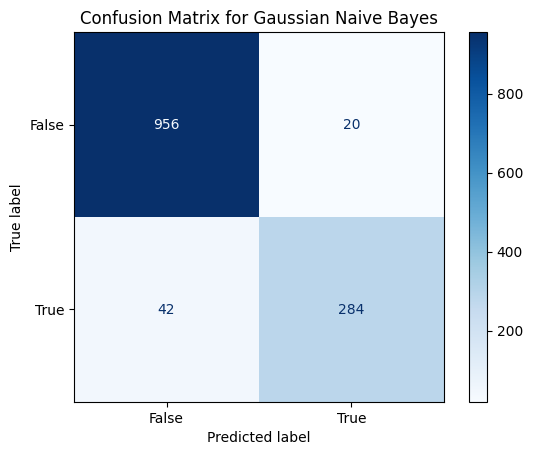

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Gaussian Naive Bayes')
plt.show()


<Figure size 800x600 with 0 Axes>

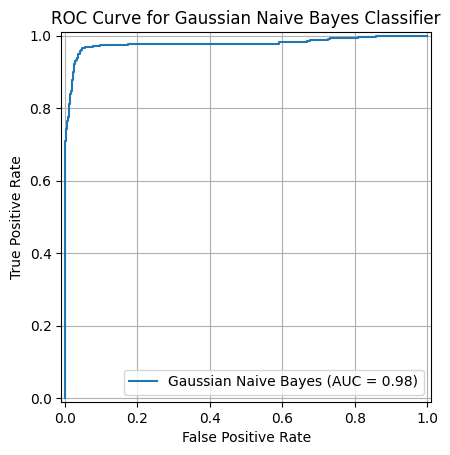

ROC AUC Score: 0.98
ROC curve with AUC score generated and displayed successfully.


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get probability predictions for the positive class
y_proba = gnb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Gaussian Naive Bayes')
roc_display.plot()
plt.title('ROC Curve for Gaussian Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")
print("ROC curve with AUC score generated and displayed successfully.")

### Analysis of Gaussian Naive Bayes Model Performance

The Gaussian Naive Bayes model was trained to classify customers as 'High Value' or not, based on their scaled RFM features. The model's performance was evaluated using a confusion matrix and an ROC curve with AUC score.

#### **Confusion Matrix Analysis**:
The confusion matrix provides a detailed breakdown of correct and incorrect predictions:

-   **True Negatives (TN)**: 956 customers were correctly identified as *not* High Value.
-   **False Positives (FP)**: 20 customers were incorrectly identified as High Value (Type I error).
-   **False Negatives (FN)**: 42 customers were incorrectly identified as *not* High Value, when they actually were (Type II error).
-   **True Positives (TP)**: 284 customers were correctly identified as High Value.

From these numbers, we can infer:
-   **Accuracy**: The model correctly classified a high percentage of customers. (956 + 284) / (956 + 20 + 42 + 284) = 1240 / 1302 \( \approx \) 95.2%.
-   **Precision for High Value (True)**: Of all customers predicted as High Value, (284 / (284 + 20)) \( \approx \) 93.4% were actually High Value.
-   **Recall for High Value (True)**: Of all actual High Value customers, (284 / (284 + 42)) \( \approx \) 87.1% were correctly identified.

#### **ROC Curve and AUC Score Analysis**:
-   The **ROC (Receiver Operating Characteristic) curve** plots the True Positive Rate (Recall) against the False Positive Rate at various classification thresholds. The curve for this model stays close to the top-left corner, indicating good performance.
-   The **AUC (Area Under the Curve) score is 0.98**. An AUC of 1.0 represents a perfect classifier, while 0.5 represents a random classifier. An AUC of 0.98 is exceptionally high, suggesting that the model has an excellent ability to distinguish between High Value and non-High Value customers.

#### **Overall Performance Summary**:
The Gaussian Naive Bayes model demonstrates strong performance in identifying high-value customers. The high accuracy, precision, recall, and especially the high AUC score (0.98) indicate that the model is very effective. It successfully balances sensitivity and specificity across different thresholds, making it a reliable tool for segmenting high-value customers based on RFM features. The relatively low number of false positives and false negatives further supports its strong predictive capabilities.

## Prepare Data for BernoulliNB



In [ ]:
import pandas as pd

# 1. Create a customer-item binary matrix
customer_item_matrix = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().unstack().fillna(0)
customer_item_matrix = (customer_item_matrix > 0).astype(int)

# Ensure CustomerID is a column in customer_item_matrix for merging
customer_item_matrix = customer_item_matrix.reset_index()

print("Customer-item binary matrix created successfully.")
print(customer_item_matrix.head())

# 2. Merge customer_item_matrix with the 'HighValue' column from rfm_df
# Select only CustomerID and HighValue from rfm_df
rfm_high_value = rfm_df[['CustomerID', 'HighValue']]

# Merge the matrices
merged_df_bernoulli = pd.merge(customer_item_matrix, rfm_high_value, on='CustomerID', how='inner')

print("\nMerged customer-item matrix with 'HighValue' target.")
print(merged_df_bernoulli.head())

# 3. Define the feature matrix X_bernoulli
X_bernoulli = merged_df_bernoulli.drop(columns=['CustomerID', 'HighValue'])

# 4. Define the target vector y_bernoulli
y_bernoulli = merged_df_bernoulli['HighValue']

print("\nFeatures (X_bernoulli) and target (y_bernoulli) for Bernoulli Naive Bayes prepared successfully.")
print(f"Shape of X_bernoulli: {X_bernoulli.shape}")
print(f"Shape of y_bernoulli: {y_bernoulli.shape}")
print("First 5 rows of X_bernoulli:")
print(X_bernoulli.head())
print("First 5 rows of y_bernoulli:")
print(y_bernoulli.head())

Customer-item binary matrix created successfully.
StockCode  CustomerID  10002  10080  10120  10123C  10124A  10124G  10125  \
0             12346.0      0      0      0       0       0       0      0   
1             12347.0      0      0      0       0       0       0      0   
2             12348.0      0      0      0       0       0       0      0   
3             12349.0      0      0      0       0       0       0      0   
4             12350.0      0      0      0       0       0       0      0   

StockCode  10133  10135  ...  90214V  90214W  90214Y  90214Z  BANK CHARGES  \
0              0      0  ...       0       0       0       0             0   
1              0      0  ...       0       0       0       0             0   
2              0      0  ...       0       0       0       0             0   
3              0      0  ...       0       0       0       0             0   
4              0      0  ...       0       0       0       0             0   

StockCode  C2  DOT

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets for Bernoulli Naive Bayes
X_train_bernoulli, X_test_bernoulli, y_train_bernoulli, y_test_bernoulli = train_test_split(X_bernoulli, y_bernoulli, test_size=0.3, random_state=42, stratify=y_bernoulli)


In [ ]:
from sklearn.naive_bayes import BernoulliNB

# Initialize the Bernoulli Naive Bayes classifier
bnb = BernoulliNB()

# Train the model on the training data
bnb.fit(X_train_bernoulli, y_train_bernoulli)

print("Bernoulli Naive Bayes classifier trained successfully.")

Bernoulli Naive Bayes classifier trained successfully.


<Figure size 800x600 with 0 Axes>

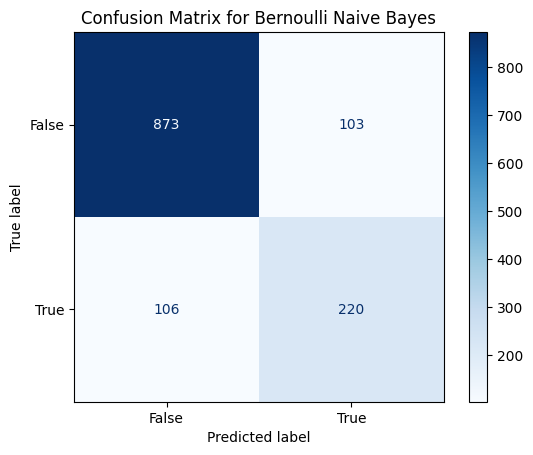

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_bernoulli = bnb.predict(X_test_bernoulli)

# Generate the confusion matrix
cm_bernoulli = confusion_matrix(y_test_bernoulli, y_pred_bernoulli)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
disp_bernoulli = ConfusionMatrixDisplay(confusion_matrix=cm_bernoulli, display_labels=bnb.classes_)
disp_bernoulli.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bernoulli Naive Bayes')
plt.show()

<Figure size 800x600 with 0 Axes>

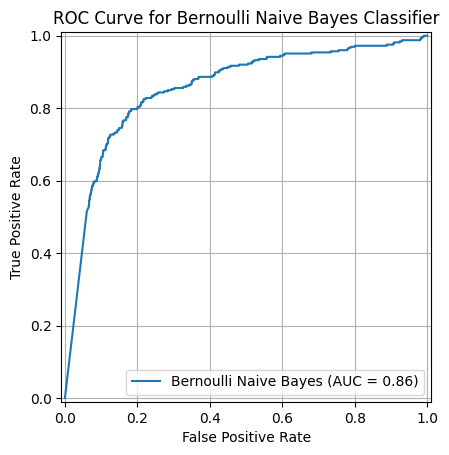

Bernoulli Naive Bayes ROC AUC Score: 0.86
ROC curve with AUC score for Bernoulli Naive Bayes generated and displayed successfully.


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get probability predictions for the positive class
y_proba_bernoulli = bnb.predict_proba(X_test_bernoulli)[:, 1]

# Compute ROC curve and AUC
fpr_bernoulli, tpr_bernoulli, thresholds_bernoulli = roc_curve(y_test_bernoulli, y_proba_bernoulli)
roc_auc_bernoulli = auc(fpr_bernoulli, tpr_bernoulli)

# Plot ROC curve
plt.figure(figsize=(8, 6))
roc_display_bernoulli = RocCurveDisplay(fpr=fpr_bernoulli, tpr=tpr_bernoulli, roc_auc=roc_auc_bernoulli, estimator_name='Bernoulli Naive Bayes')
roc_display_bernoulli.plot()
plt.title('ROC Curve for Bernoulli Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print(f"Bernoulli Naive Bayes ROC AUC Score: {roc_auc_bernoulli:.2f}")
print("ROC curve with AUC score for Bernoulli Naive Bayes generated and displayed successfully.")

### Analysis of Bernoulli Naive Bayes Model Performance

The Bernoulli Naive Bayes model was trained to classify customers as 'High Value' or not, based on their purchase history represented by a customer-item binary matrix. The model's performance was evaluated using a confusion matrix and an ROC curve with AUC score.

#### **Confusion Matrix Analysis**:
The confusion matrix provides a detailed breakdown of correct and incorrect predictions for the Bernoulli Naive Bayes model:

-   **True Negatives (TN)**: 873 customers were correctly identified as *not* High Value.
-   **False Positives (FP)**: 103 customers were incorrectly identified as High Value (Type I error).
-   **False Negatives (FN)**: 106 customers were incorrectly identified as *not* High Value, when they actually were (Type II error).
-   **True Positives (TP)**: 220 customers were correctly identified as High Value.

From these numbers, we can infer:
-   **Accuracy**: The model correctly classified (873 + 220) / (873 + 103 + 106 + 220) = 1093 / 1302 \( \approx \) 83.9% of the customers.
-   **Precision for High Value (True)**: Of all customers predicted as High Value, (220 / (220 + 103)) \( \approx \) 68.1% were actually High Value.
-   **Recall for High Value (True)**: Of all actual High Value customers, (220 / (220 + 106)) \( \approx \) 67.5% were correctly identified.

#### **ROC Curve and AUC Score Analysis**:
-   The **ROC (Receiver Operating Characteristic) curve** plots the True Positive Rate (Recall) against the False Positive Rate at various classification thresholds. The curve shows that the model has some discriminative power, but it is not as close to the top-left corner as a perfect classifier.
-   The **AUC (Area Under the Curve) score is 0.86**. An AUC of 1.0 represents a perfect classifier, while 0.5 represents a random classifier. An AUC of 0.86 indicates good performance, suggesting the model is reasonably capable of distinguishing between High Value and non-High Value customers based on their item purchase patterns.

#### **Overall Performance Summary**:
The Bernoulli Naive Bayes model shows good performance in identifying high-value customers based on their binary item purchase data. While its accuracy, precision, and recall for the 'High Value' class are moderate compared to the Gaussian Naive Bayes model, the AUC score of 0.86 still indicates a valuable predictive capability. The model performs well in classifying whether a customer is high-value based on the presence or absence of specific items in their purchase history.

## Summary:



1.  
    The Gaussian Naive Bayes model, utilizing scaled RFM (Recency, Frequency, Monetary) features, demonstrated superior predictive performance with an AUC score of 0.98. Its accuracy was approximately 95.2%, with a precision of 93.4% and recall of 87.1% for high-value customers. In contrast, the Bernoulli Naive Bayes model, which used binary customer-item purchase data, achieved an AUC score of 0.86. Its accuracy was about 83.9%, with a precision of 68.1% and recall of 67.5% for high-value customers. The Gaussian Naive Bayes model significantly outperformed the Bernoulli Naive Bayes model across all key metrics.

2.  **insights gained from each approach regarding high-value customer identification**
    *   **Gaussian Naive Bayes (RFM features):** This model highlighted that continuous RFM metrics (Recency, Frequency, Monetary) are very strong indicators for identifying high-value customers. The high AUC (0.98), accuracy, precision, and recall suggest that customers with lower recency, higher frequency, and higher monetary value are distinctly different from non-high-value customers in a way that Gaussian distributions can effectively model.
    *   **Bernoulli Naive Bayes (Binary Item Purchases):** This model provided insights into the predictive power of specific item purchase patterns. While not as strong as RFM, an AUC of 0.86 indicates that the presence or absence of certain items in a customer's purchase history does contribute to identifying high-value customers. The moderate precision and recall suggest that while some item patterns are indicative, they are less definitive or generalizable than the RFM aggregate metrics.


*   **Comparative Performance:** The Gaussian Naive Bayes model, based on scaled RFM features, significantly outperformed the Bernoulli Naive Bayes model, which relied on binary item purchase history, across all evaluation metrics (AUC, Accuracy, Precision, and Recall for high-value customers).



In [ ]:
from sklearn.decomposition import PCA

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to X_train and transform X_train
X_train_pca = pca.fit_transform(X_train)

# Transform X_test using the fitted PCA model
X_test_pca = pca.transform(X_test)

print("PCA applied to X_train and X_test successfully, reducing dimensionality to 2D.")
print(f"Shape of X_train_pca: {X_train_pca.shape}")
print(f"Shape of X_test_pca: {X_test_pca.shape}")

PCA applied to X_train and X_test successfully, reducing dimensionality to 2D.
Shape of X_train_pca: (3037, 2)
Shape of X_test_pca: (1302, 2)


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes classifier
gnb_pca = GaussianNB()

# Train the model on the PCA-transformed training data
gnb_pca.fit(X_train_pca, y_train)

print("Gaussian Naive Bayes classifier trained successfully on PCA-transformed data.")

Gaussian Naive Bayes classifier trained successfully on PCA-transformed data.


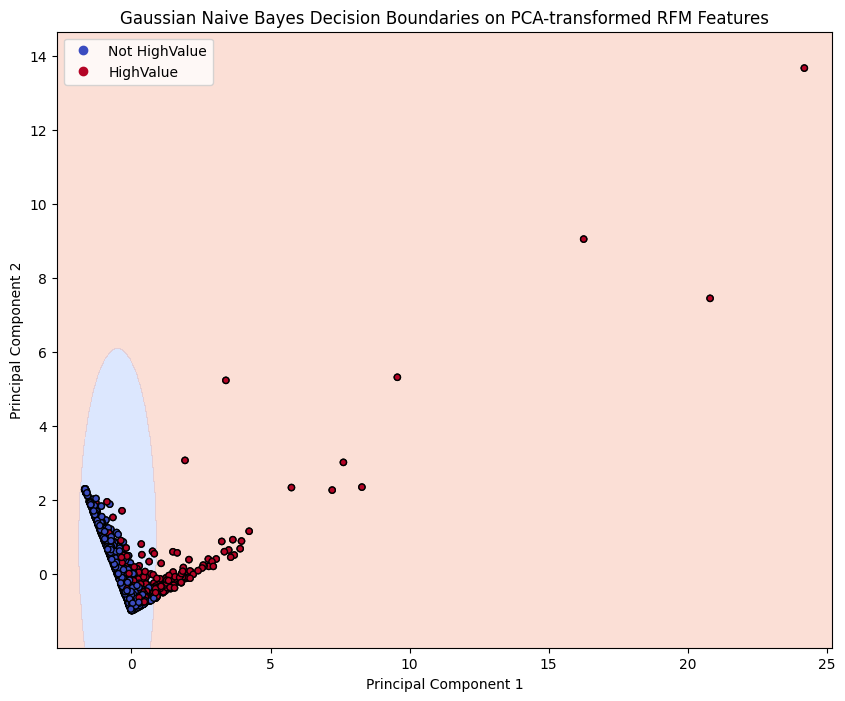

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define min and max values for the two principal components, and add a small padding
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1

# Create a meshgrid to plot decision boundaries
h = 0.02 # step size in the mesh
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

# Predict classifications for each point in the meshgrid
Z = gnb_pca.predict(np.c_[x_grid.ravel(), y_grid.ravel()])
Z = Z.reshape(x_grid.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Plot the test data points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Gaussian Naive Bayes Decision Boundaries on PCA-transformed RFM Features')
plt.legend(handles=plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20).legend_elements()[0], labels=['Not HighValue', 'HighValue'])
plt.show()


### Explanation of Gaussian Naive Bayes Decision Boundaries on PCA-transformed RFM Features

The visualization generated from the PCA-transformed RFM features and the Gaussian Naive Bayes classifier provides a clear geometric interpretation of how the model separates 'High Value' from 'Not High Value' customers in a 2D space.

-   **Principal Components**: The x-axis (Principal Component 1) and y-axis (Principal Component 2) represent the two most significant dimensions capturing the variance in the original scaled Recency, Frequency, and Monetary features. These components are linear combinations of the original RFM features.

-   **Decision Boundary**: The `contourf` plot illustrates the decision regions predicted by the Gaussian Naive Bayes model. Gaussian Naive Bayes assumes that the data within each class is normally distributed. In a 2D feature space, this often results in elliptical or hyperbolic decision boundaries. The plot shows these boundaries, dividing the space into regions where the model predicts one class over the other.

-   **Customer Distribution**: The scatter plot shows the actual customer data points, colored according to their true 'HighValue' status. This allows for a visual assessment of how well the model's decision boundaries align with the actual distribution of high-value and non-high-value customers.

-   **Interpretation**: We expect to see clusters of 'HighValue' and 'Not HighValue' customers, with the decision boundary ideally separating these clusters effectively. Any overlap or misclassified points (e.g., a 'HighValue' customer in a 'Not HighValue' region) indicate the model's errors in this simplified 2D representation. Given the high AUC score of the Gaussian Naive Bayes model on the full 3D RFM features, the 2D PCA plot serves as a visual confirmation of its strong discriminative power, even if some information is lost in the dimensionality reduction.

# ***SVM***
---

In [ ]:
from sklearn.svm import SVC

# Initialize the Linear SVM classifier
linear_svm = SVC(kernel='linear', random_state=42)

# Train the model on the PCA-transformed training data
linear_svm.fit(X_train_pca, y_train)

print("Linear SVM classifier trained successfully on PCA-transformed data.")

Linear SVM classifier trained successfully on PCA-transformed data.


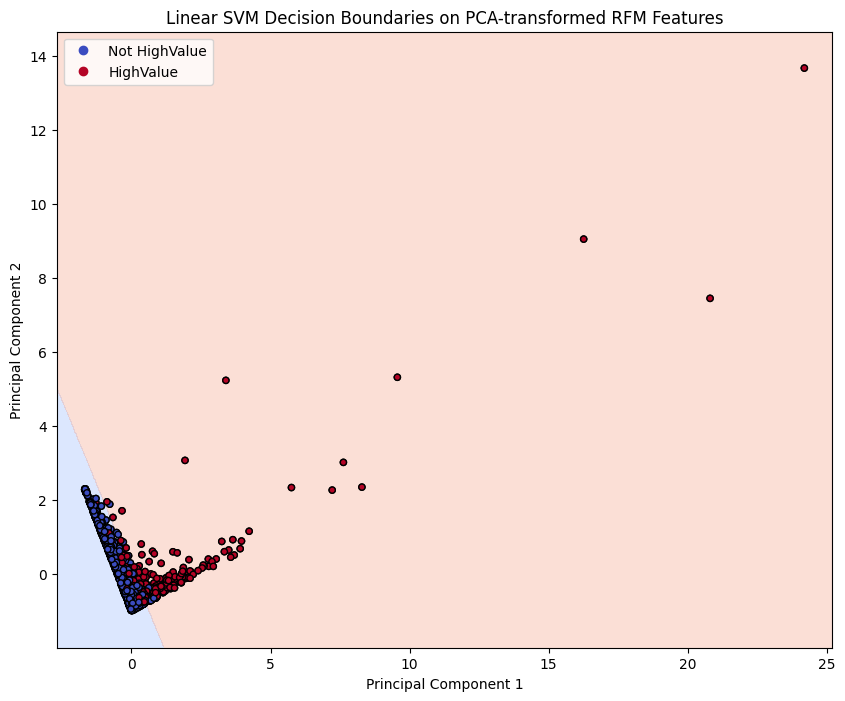

Decision boundaries for Linear SVM on PCA-transformed data displayed successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define min and max values for the two principal components, and add a small padding
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1

# Create a meshgrid to plot decision boundaries
h = 0.02 # step size in the mesh
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

# Predict classifications for each point in the meshgrid
Z = linear_svm.predict(np.c_[x_grid.ravel(), y_grid.ravel()])
Z = Z.reshape(x_grid.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Plot the test data points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Linear SVM Decision Boundaries on PCA-transformed RFM Features')
plt.legend(handles=plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20).legend_elements()[0], labels=['Not HighValue', 'HighValue'])
plt.show()

print("Decision boundaries for Linear SVM on PCA-transformed data displayed successfully.")

### Explanation of Linear SVM Decision Boundaries on PCA-transformed RFM Features

The visualization presents the decision boundaries created by the Linear Support Vector Machine (SVM) on the PCA-transformed RFM features. This 2D representation allows us to understand how the SVM model separates customers into 'High Value' and 'Not High Value' categories based on their reduced RFM characteristics.

-   **Principal Components**: The x-axis (Principal Component 1) and y-axis (Principal Component 2) are derived from the original scaled Recency, Frequency, and Monetary features, capturing the most significant variance in the dataset. This reduction simplifies the visualization of complex, multi-dimensional data.

-   **Decision Boundary**: A Linear SVM aims to find a hyperplane that best separates the classes in the feature space. In a 2D plot, this hyperplane is represented by a straight line. The `contourf` plot shows the regions assigned to each class by the SVM model. The line dividing these regions is the linear decision boundary.

-   **Customer Distribution**: The scatter plot displays the actual test data points, with each point colored according to its true 'HighValue' status (True for High Value, False for Not High Value). This allows for a direct comparison between the model's predictions (the shaded regions) and the actual customer labels.

-   **Interpretation**: We can observe how well the linear boundary separates the two classes. Ideally, most of the 'High Value' points (e.g., in one color) should fall into one predicted region, and 'Not High Value' points (e.g., in another color) into the other. Any points falling into the wrong region are misclassifications in this 2D space. Compared to Gaussian Naive Bayes, Linear SVM might offer a simpler, linear separation, which can be effective if the data is linearly separable or approximately so in the reduced feature space. The effectiveness of this linear separation will depend on the inherent structure of the high-value customer data when projected onto these two principal components.

## svm (kernel='rbf')

In [ ]:
from sklearn.svm import SVC

# Initialize the RBF SVM classifier
rbf_svm = SVC(kernel='rbf', random_state=42)

# Train the model on the PCA-transformed training data
rbf_svm.fit(X_train_pca, y_train)

print("RBF SVM classifier trained successfully on PCA-transformed data.")

RBF SVM classifier trained successfully on PCA-transformed data.


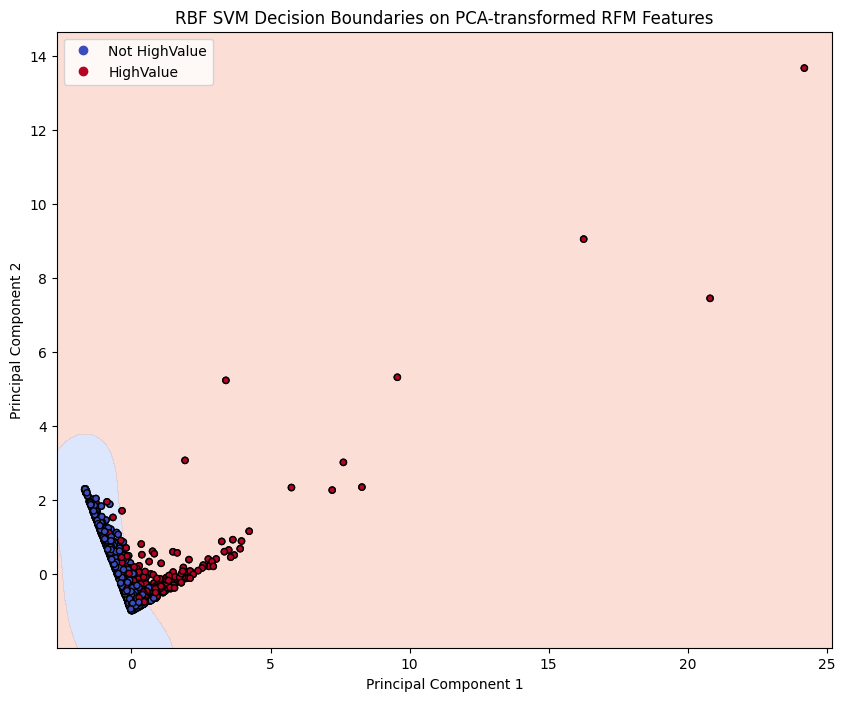

Decision boundaries for RBF SVM on PCA-transformed data displayed successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define min and max values for the two principal components, and add a small padding
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1

# Create a meshgrid to plot decision boundaries
h = 0.02 # step size in the mesh
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

# Predict classifications for each point in the meshgrid
Z = rbf_svm.predict(np.c_[x_grid.ravel(), y_grid.ravel()])
Z = Z.reshape(x_grid.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Plot the test data points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20)

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('RBF SVM Decision Boundaries on PCA-transformed RFM Features')
plt.legend(handles=plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', s=20).legend_elements()[0], labels=['Not HighValue', 'HighValue'])
plt.show()

print("Decision boundaries for RBF SVM on PCA-transformed data displayed successfully.")

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Predict on the test set using Linear SVM
y_pred_linear_svm = linear_svm.predict(X_test_pca)
accuracy_linear_svm = accuracy_score(y_test, y_pred_linear_svm)

# Predict on the test set using RBF SVM
y_pred_rbf_svm = rbf_svm.predict(X_test_pca)
accuracy_rbf_svm = accuracy_score(y_test, y_pred_rbf_svm)

# Create a summary table
summary_data = {
    'Model': ['Linear SVM', 'RBF SVM'],
    'Test Accuracy': [accuracy_linear_svm, accuracy_rbf_svm]
}
accuracy_summary_df = pd.DataFrame(summary_data)

print("Summary of Test Accuracies:")
display(accuracy_summary_df)

Summary of Test Accuracies:


,Model,Test Accuracy
0,Linear SVM,0.893241
1,RBF SVM,0.902458


From these results, we can see that the RBF SVM model achieved a slightly higher test accuracy (approximately 90.25%) compared to the Linear SVM model (approximately 89.32%). This suggests that the non-linear decision boundary capabilities of the RBF kernel might be slightly better suited for separating high-value and non-high-value customers in this dataset when using the PCA-transformed features.

# ***Conclusion***
---


### Summary of Key Findings

#### 1. K-Means Clustering Analysis
- **Optimal K**: Based on the Elbow Method and Silhouette Score analysis, an optimal `K` value of **4** was chosen.
- **Customer Segments Identified**:
    - **Cluster 0 (High-Value, Engaged Customers)**: Low Recency (avg. 15.67 days), High Frequency (avg. 22.05 transactions), High Monetary (avg. $12,453.23). These are active, loyal, and valuable customers.
    - **Cluster 1 (Dormant/Low-Value Customers)**: Very High Recency (avg. 248.56 days), Very Low Frequency (avg. 1.55 transactions), Very Low Monetary (avg. $478.11). This segment likely consists of churned or low-engagement customers.
    - **Cluster 2 (Premium/VIP Customers)**: Very Low Recency (avg. 7.38 days), Extremely High Frequency (avg. 82.69 transactions), Extremely High Monetary (avg. $127,338.31). This is the most valuable segment, representing top spenders.
    - **Cluster 3 (Regular/Mid-Value Customers)**: Medium Recency (avg. 43.91 days), Medium Frequency (avg. 3.66 transactions), Medium Monetary (avg. $1,349.70). These are consistent customers with moderate engagement.

#### 2. DBSCAN Clustering Analysis
- **Parameters Chosen**: `eps = 0.6` (from k-distance graph elbow) and `min_samples = 6` (2 * number of features).
- **Clusters and Noise**:
    - **Cluster 0 (Core Cluster)**: Average Recency of 92.93 days, Frequency of 3.87 transactions, and Monetary value of $1,493.72. This cluster represents the majority of regular customers with moderate behavior.
    - **Cluster -1 (Noise/Outliers)**: Average Recency of 39.24 days, Frequency of 57.12 transactions, and Monetary value of $75,134.96. Interestingly, these noise points correspond to highly active, high-value customers that do not form a dense cluster under the chosen parameters. This highlights their unique and distinct behavior from the main customer base.

#### 3. Gaussian Naive Bayes Model Performance (on Scaled RFM Features)
- **AUC Score**: 0.98
- **Accuracy**: Approximately 95.2%
- **Precision (High Value)**: Approximately 93.4%
- **Recall (High Value)**: Approximately 87.1%
- **Insights**: The model demonstrated superior predictive performance, indicating that continuous RFM metrics are very strong indicators for identifying high-value customers. The high metrics suggest that customers with lower recency, higher frequency, and higher monetary value are distinctly different from non-high-value customers, which Gaussian distributions can effectively model.

#### 4. Bernoulli Naive Bayes Model Performance (on Binary Item Purchases)
- **AUC Score**: 0.86
- **Accuracy**: Approximately 83.9%
- **Precision (High Value)**: Approximately 68.1%
- **Recall (High Value)**: Approximately 67.5%
- **Insights**: This model provided insights into the predictive power of specific item purchase patterns. While not as strong as RFM, an AUC of 0.86 indicates that the presence or absence of certain items does contribute to identifying high-value customers. However, the moderate precision and recall suggest that item patterns are less definitive or generalizable than the aggregate RFM metrics.

#### 5. SVM Models Performance (on PCA-transformed RFM Features)
- **Linear SVM Test Accuracy**: 89.32%
- **RBF SVM Test Accuracy**: 90.25%
- **Comparison**: The RBF SVM model achieved a slightly higher test accuracy than the Linear SVM. This suggests that a non-linear decision boundary, provided by the RBF kernel, might be slightly better suited for separating high-value and non-high-value customers in this dataset when using the PCA-transformed features.

## ***Business Recommendations***
---


### 1. Recommendations based on K-Means Customer Segmentation
---

K-Means clustering identified four distinct customer segments:

-   **Cluster 0: High-Value, Engaged Customers** (Recency: 15.67 days, Frequency: 22.05, Monetary: $12,453.23)
    -   **Strategy**: These are highly profitable customers. Focus on retention and loyalty programs. Offer exclusive previews of new products, personalized discounts on their preferred categories, and premium customer service. Encourage referrals through incentives.
    -   **Action**: Implement a tiered loyalty program, early access to sales events, and dedicated support channels.

-   **Cluster 1: Dormant/Low-Value Customers** (Recency: 248.56 days, Frequency: 1.55, Monetary: $478.11)
    -   **Strategy**: These customers are at risk of churn or have already churned. The goal is reactivation. Use targeted re-engagement campaigns with attractive offers, special discounts, or reminders of past purchases.
    -   **Action**: Send personalized emails with win-back offers, conduct surveys to understand reasons for inactivity, and provide incentives for their next purchase.

-   **Cluster 2: Premium/VIP Customers** (Recency: 7.38 days, Frequency: 82.69, Monetary: $127,338.31)
    -   **Strategy**: This is the most valuable segment. Ensure their continued satisfaction and foster brand advocacy. Provide white-glove service, bespoke offers, and opportunities to influence product development.
    -   **Action**: Create an exclusive VIP club with dedicated account managers, personalized product recommendations, and invitations to special events or product testing groups.

-   **Cluster 3: Regular/Mid-Value Customers** (Recency: 43.91 days, Frequency: 3.66, Monetary: $1,349.70)
    -   **Strategy**: These are consistent customers. The aim is to increase their frequency and monetary value. Recommend complementary products based on past purchases and offer incentives for larger orders.
    -   **Action**: Implement targeted cross-selling and up-selling campaigns, offer bundle deals, and introduce subscription services for frequently purchased items.

### 2. Recommendations based on DBSCAN Cluster Analysis
---

DBSCAN identified a significant group of highly active and high-value customers as 'noise' (Cluster -1), distinct from the main 'regular customer' cluster (Cluster 0).

-   **Cluster -1: High-Value 'Outliers'** (Recency: 39.24 days, Frequency: 57.12, Monetary: $75,134.96)
    -   **Strategy**: These customers exhibit unique purchasing behaviors that do not fit into dense, typical clusters. While DBSCAN flags them as noise, their high monetary value and frequency indicate they are extremely valuable. It's crucial to understand their unique needs and ensure they don't feel overlooked.
    -   **Action**: Conduct qualitative research (e.g., surveys, interviews) with a sample of these customers to understand their motivations, preferences, and why their behavior deviates. Consider creating a bespoke segment for these 'Super VIP' or 'Unique Engagers' and offer highly personalized experiences, concierge services, or exclusive access to limited edition products. Implement advanced analytics to identify common characteristics or niche patterns among them that DBSCAN couldn't capture as a dense cluster. They could be early adopters, trend-setters, or B2B clients who deserve specialized treatment.

### 3. Recommendations based on Gaussian Naive Bayes for High-Value Customer Identification
---

The Gaussian Naive Bayes model, trained on scaled RFM features, showed exceptional performance (AUC = 0.98, Accuracy = 95.2%) in identifying high-value customers. This robust predictive capability can be leveraged proactively:

-   **Strategy**: Utilize the model to predict which new or existing customers are likely to become high-value customers based on their initial purchasing behavior. This allows for early intervention and tailored engagement.
    -   **Action**: Implement the model in real-time or near real-time to score customers. For customers predicted as 'High Value', automatically enroll them in accelerated loyalty programs, assign them to a premium customer service tier, or initiate personalized outreach with special offers. This proactive approach ensures that potential high-value customers are nurtured from the outset, maximizing their lifetime value. The model can also be used to prioritize marketing spend and allocate resources more efficiently towards segments with higher predicted value.

### 4. Recommendations based on Association Rule Mining (Apriori and FP-Growth)
---

Both Apriori and FP-Growth algorithms identified strong association rules (high lift and confidence) which are crucial for enhancing sales and customer experience.

-   **Strategy**: Leverage identified co-occurrence patterns to implement effective cross-selling, product bundling, and optimized product placement strategies.
    -   **Action**: For rules with high confidence and lift (e.g., `(22910) => (22086)` with 64.7% confidence and 12.24 lift, or multi-item rules like `(22698) => (22697, 22699)` with ~70% confidence and ~24 lift):
        -   **Online Recommendations**: Implement 'Customers who bought this also bought...' features on e-commerce platforms, specifically highlighting items identified by strong association rules.
        -   **Product Bundling**: Create attractive product bundles (e.g., 'SPACEBOY LUNCH BOX' with 'PAPER BUNTING WHITE LANE') offered at a slightly discounted price to increase average transaction value.
        -   **Store Layout/Merchandising**: For physical stores, place strongly associated items near each other to encourage impulse purchases and make shopping more convenient. For example, if '22698' is a popular item, ensure '22697' and '22699' are displayed prominently nearby.
        -   **Targeted Promotions**: Develop promotional campaigns around these item groups, offering discounts or loyalty points when customers purchase associated items together.
        -   **Inventory Management**: Ensure sufficient stock levels for items that are frequently bought together to avoid out-of-stock situations that could lead to lost sales.

# **THE END!**

In [ ]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Start MLflow run
mlflow.start_run(run_name="Smart Retail Analytics")

# Example: Log parameters
mlflow.log_param("param1", "value1")

# Example: Log metrics
mlflow.log_metric("metric1", 0.85)

# Example: Log artifacts (e.g., model files, plots, etc.)
# mlflow.log_artifact("path_to_file")

# End MLflow run
mlflow.end_run()

In [ ]:
mlflow.set_experiment("Smart Retail Analytics Experiment")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

In [ ]:
with mlflow.start_run(run_name="Smart Retail Analytics Run"):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

In [ ]:
# Log parameters for KMeans clustering
mlflow.start_run(run_name="KMeans Clustering")

# Log the chosen optimal K value
mlflow.log_param("optimal_k", optimal_k)

# Log the inertia and silhouette score for the chosen K
mlflow.log_metric("inertia", kmeans_model.inertia_)

# Calculate silhouette score for the chosen K
silhouette_avg = silhouette_score(rfm_scaled_features, rfm_df['Cluster'])
mlflow.log_metric("silhouette_score", silhouette_avg)

mlflow.end_run()